# ОИАД. Лабораторная работа №4

Используйте набор данных **datasets/famcs_students.csv**

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную $y=$ binary_cols[N % 8], где $N$ - номер в списке группы. Остальные переменные используйте в качестве признаков $X$ (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации $y$ по признакам $X$.

Разделите случайно исходные данные на 3 выборки:
* тренировочная (70%) - для определения параметров модели
* валидацонная (15%) - для подбора гиперпараметров модели
* тестовую (15%) - итоговая оценка качества

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

df = pd.read_csv('../datasets/famcs_students.csv')
 
# 4, 5 
N = 10   
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
numeric_features = ['work_experience','social','sport','hostel',
                    'cource', 'group', 'age', 'height', 'foot_size', 'score', 'retake', 'miss']

for col in binary_cols:
    if col in df.columns:
        if col in ['study_form']:
            df[col] = (df[col] == 'Бюджет').astype(int)
        elif col in ['interest']:
            df[col] = (df[col] == 'Математика').astype(int)
        else:
            df[col] = (df[col] == 'Да').astype(int)


df['sex'] = (df['sex'] == 'М').astype(int)
df['study_form'] = (df['study_form'] == 'Бюджет').astype(int)

work_experience_map = {
    "Не работаю": 0,
    "Меньше года": 1,
    "1-2 года": 1.5,
    "более 2 лет": 2
}
df['work_experience'] = df['work_experience'].map(work_experience_map)

retake_map = {
    "0": 0,
    "1": 1,
    "2+": 2,
}
df['retake'] = df['retake'].map(retake_map)

# social_map = ["Экстраверт", "Интроверт", "Социофоб"]
df['social'] = df['social'].astype(str)
social_dummies = pd.get_dummies(df['social'], prefix='social')
for col in social_dummies.columns:
    social_dummies[col] = social_dummies[col].astype(int)
df = pd.concat([df, social_dummies], axis=1)


# os_map = ["MacOS", "Windows", "Linux"]
df['os'] = df['os'].astype(str)
os_dummies = pd.get_dummies(df['os'], prefix='os')
for col in os_dummies.columns:
    os_dummies[col] = os_dummies[col].astype(int)
df = pd.concat([df, os_dummies], axis=1)


sport_map = {
    "Вообще нет": 0,
    "Редко, легкая физкультура": 1,
    "Да, я спортсмен": 2
}

df['sport'] = df['sport'].map(sport_map)

hostel_map = {
    "Да": 1,
    "Нет, я из Минска": 0,
    "Нет, я из регионов": 0
}

df['hostel'] = df['hostel'].map(hostel_map)

target_col = binary_cols[N % 8]
print(f"Целевая переменная: {target_col}")


y = df[target_col].values

counts = Counter(y)
print("Количество значений в целевой переменной:")
print(f"0: {counts[0]}; Доля 0: {counts[0] / len(y):.3f}")
print(f"1: {counts[1]}; Доля 1: {counts[1] / len(y):.3f}")


# Выбор признаков (минимум 5)
# N = 10
feature_sets = {
    'strong_predictors': ['interest', 'score', 'miss', 'work_experience', 'study_form'],
    'behavioral':       ['anime', 'bad_sleep', 'sport', 'social_Интроверт', 'hostel'],
    'demographic_noise':['age', 'sex', 'height', 'foot_size', 'eye_color'],
    'mixed_interact':   ['interest', 'score', 'social_Социофоб', 'miss', 'ss', 'retake', 'work_experience'],
    'quick_minimal':    ['score', 'miss', 'bad_sleep', 'anime', 'sport'],
    'selected_features_1': ['score', 'miss', 'retake', 'work_experience', 'bad_sleep'],
    'selected_features_2': ['work_experience', 'miss', 'sport', 'bad_sleep', 'score'],
    'selected_features_3': ['bad_sleep', 'social_Интроверт', 'social_Социофоб', 'interest', 'sport'],
    'selected_features_4': ['score', 'miss', 'glasses', 'anime', 'literature'],
    'selected_features_5': ['height', 'foot_size', 'age', 'glasses', 'anime']
}

# N = 5 
# selected_features_1 = ['interest', 'social_Интроверт', 'social_Социофоб', 'literature', 'age']
# selected_features_2 = ['bad_sleep', 'weekend_study', 'sport', 'hostel', 'work_experience']
# selected_features_3 = ['glasses', 'social_Интроверт', 'bad_sleep', 'sport', 'interest']
# selected_features_4 = ['interest', 'literature', 'age', 'height', 'foot_size']
# selected_features_5 = ['score', 'miss', 'retake', 'study_form', 'cource']

# feature_sets = {
#     'strong_demographic': ['sex','age','interest','social_Интроверт','stream'],
#     'behavioral':          ['os','ai','weekend_study','bad_sleep','ss'],
#     'academic':            ['score','miss','retake','work_experience','study_form'],
#     'social_hobby':        ['hostel','sport','literature','ss','interest'],
#     'noise':               ['height','foot_size','eye_color','group','cource']
# }


selected_features = feature_sets['strong_predictors']
print(f"Используемые признаки: {selected_features}")

X = df[selected_features].fillna(df[selected_features].median()).values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1  
X_normalized = (X - X_mean) / X_std

np.random.seed(42)
n = len(X)
indices = np.random.permutation(n)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

X_train, y_train = X_normalized[train_idx], y[train_idx]
X_val, y_val = X_normalized[val_idx], y[val_idx]
X_test, y_test = X_normalized[test_idx], y[test_idx]

print(f"Размеры выборок: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

Целевая переменная: weekend_study
Количество значений в целевой переменной:
0: 28; Доля 0: 0.220
1: 99; Доля 1: 0.780
Используемые признаки: ['interest', 'score', 'miss', 'work_experience', 'study_form']
Размеры выборок: train=88, val=19, test=20


**Бинарная классификация** - это задача машинного обучения, где нужно отнести объект к одному из двух классов. Например:
- Письмо: спам (1) или не спам (0)
- Студент: носит очки (1) или не носит (0)
- Транзакция: мошенническая (1) или легитимная (0)

У нас есть:
- **X** - признаки (features) - характеристики объекта (возраст, рост, оценки)
- **y** - метка класса (label) - 0 или 1
- **Цель** - научиться предсказывать y по X для новых объектов


## 0. Тривиальный классификатор

Всегда выдает наиболее частый класс

---

Тривиальный классификатор всегда предсказывает наиболее частый класс из обучающей выборки. Это базовая модель для сравнения.

Находим самый частый класс в обучающей выборке и всегда возвращаем его как предсказание.

Любая полезная модель должна быть лучше тривиальной.
Если сложная модель хуже тривиальной - что-то пошло не так.

In [2]:
class TrivialClassifier:
    def __init__(self):
        self.most_frequent_class = None
    
    def fit(self, X, y):
        class_counts = Counter(y)
        self.most_frequent_class = max(class_counts, key=class_counts.get)
        return self
    
    def predict(self, X):
        return np.array([self.most_frequent_class] * len(X))
    
    def predict_proba(self, X):
        proba = np.zeros((len(X), 2))
        proba[:, self.most_frequent_class] = 1.0
        return proba

trivial_model = TrivialClassifier()
trivial_model.fit(X_train, y_train)

## 1. Наивный байесовский классификатор

Алгоритм реализуйте сами!

---

Наивный байесовский классификатор использует теорему Байеса с предположением о независимости признаков. Для каждого класса вычисляем вероятности признаков, затем используем их для предсказания.

Вычисляем априорные вероятности классов и условные вероятности признаков при условии класса, используя нормальное распределение для непрерывных признаков.

### Теорема Байеса

**Формула Байеса:**

```
P(класс|признаки) = P(признаки|класс) × P(класс) / P(признаки)
```

Расшифровка:
- **P(класс|признаки)** - вероятность класса при данных признаках (что мы ищем)
- **P(признаки|класс)** - вероятность увидеть такие признаки у этого класса
- **P(класс)** - априорная вероятность класса (как часто встречается)
- **P(признаки)** - вероятность увидеть такие признаки вообще

### Почему "наивный"

Предполагаем **независимость** признаков. Это наивно, потому что в реальности признаки часто связаны (высокий рост → большой размер обуви).

**С учетом независимости:**

```
P(x₁,x₂,...,xₙ|класс) = P(x₁|класс) × P(x₂|класс) × ... × P(xₙ|класс)
```

### Для непрерывных признаков

```
P(x|класс) = 1/(σ√(2π)) × exp(-½((x-μ)/σ)²)

где:
- μ - среднее значение признака для класса
- σ - стандартное отклонение
- x - значение признака
```

### Алгоритм

**Обучение:**
1. Для каждого класса вычисляем:
   - Долю объектов этого класса: P(класс)
   - Среднее μ и отклонение σ для каждого признака

**Предсказание для нового объекта:**
1. Для каждого класса вычисляем:
   ```
   Score(класс) = log P(класс) + Σ log P(xᵢ|класс)
   ```
2. Выбираем класс с максимальным Score


### Пример

Задача: предсказать, носит ли студент очки

Обучающие данные:
Класс "носит очки":    рост = 170±10 см, возраст = 20±2 года
Класс "не носит очки": рост = 175±12 см, возраст = 19±3 года

Новый студент: рост = 168 см, возраст = 21 год

P(очки) = 0.4, P(нет очков) = 0.6

Score(очки) = log(0.4) + log(P(168|μ=170,σ=10)) + log(P(21|μ=20,σ=2))
Score(нет) = log(0.6) + log(P(168|μ=175,σ=12)) + log(P(21|μ=19,σ=3))

Выбираем класс с большим Score

In [3]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.feature_stats = {}
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = len(y)
        
        for c in self.classes:
            # Априорная вероятность класса
            mask = (y == c)
            self.class_priors[c] = np.sum(mask) / n_samples
            
            # Параметры распределения признаков для класса
            X_class = X[mask]
            self.feature_stats[c] = {
                'mean': X_class.mean(axis=0),
                'std': X_class.std(axis=0) + 1e-6
            }
        return self
    
    def _gaussian_pdf(self, x, mean, std):
        return np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        proba = np.zeros((n_samples, len(self.classes)))
        
        for i, c in enumerate(self.classes):
            log_prior = np.log(self.class_priors[c])
            
            # Логарифм произведения условных вероятностей
            log_likelihood = np.sum(
                np.log(self._gaussian_pdf(
                    X, 
                    self.feature_stats[c]['mean'],
                    self.feature_stats[c]['std']
                ) + 1e-10),
                axis=1
            )
            
            proba[:, i] = log_prior + log_likelihood
        
        proba = np.exp(proba - np.max(proba, axis=1, keepdims=True))
        proba = proba / np.sum(proba, axis=1, keepdims=True)
        
        return proba
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes[np.argmax(proba, axis=1)]

nb_model = NaiveBayesClassifier()
_ = nb_model.fit(X_train, y_train)

## 2. Метод k-ближайших соседей

Алгоритм реализуйте сами!
Подберите оптимальный гиперпараметр $k$.

---

k-NN классифицирует объект по большинству голосов его k ближайших соседей. Расстояние обычно измеряется евклидовой метрикой.

Реализуем поиск k ближайших соседей и голосование. Подбираем оптимальное k на валидационной выборке.

1. Сохраняем всю обучающую выборку
2. Для нового объекта:
   - Находим k ближайших объектов из обучающей выборки
   - Смотрим их классы
   - Предсказываем класс большинства

### Расстояние между объектами

```
d(A, B) = √[(x₁ᴬ - x₁ᴮ)² + (x₂ᴬ - x₂ᴮ)² + ... + (xₙᴬ - xₙᴮ)²]
```

### Нормализация

Без нормализации:
- Возраст: от 18 до 25 (разброс ~7)
- Зарплата: от 20,000 до 100,000 (разброс ~80,000)

Зарплата "перевесит" возраст при вычислении расстояния.
После нормализации все признаки имеют среднее 0 и отклонение 1.

### Пример

k = 3
Новый студент X

Расстояния до всех точек обучающей выборки:
```
Студент1 (класс 0): расстояние 2.1
Студент2 (класс 1): расстояние 1.5  ← сосед 2
Студент3 (класс 1): расстояние 3.2
Студент4 (класс 0): расстояние 1.2  ← сосед 1
Студент5 (класс 1): расстояние 1.8  ← сосед 3
```

3 ближайших: классы [0, 1, 1]

Голосование: класс 1 (2 голоса из 3)

In [4]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))
    
    def predict(self, X):
        predictions = []
        
        for x in X:
            distances = self._euclidean_distance(self.X_train, x)
            
            k_nearest_idx = np.argpartition(distances, self.k)[:self.k]
            k_nearest_labels = self.y_train[k_nearest_idx]
            
            prediction = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(prediction)
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        proba = np.zeros((n_samples, 2))
        
        for i, x in enumerate(X):
            distances = self._euclidean_distance(self.X_train, x)
            k_nearest_idx = np.argpartition(distances, self.k)[:self.k]
            k_nearest_labels = self.y_train[k_nearest_idx]
            
            for c in [0, 1]:
                proba[i, c] = np.sum(k_nearest_labels == c) / self.k
        
        return proba

def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

best_k = 1
best_accuracy = 0

for k in range(1, 21, 2): 
    knn = KNNClassifier(k=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    accuracy = calculate_accuracy(y_val, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Оптимальное k: {best_k}, accuracy на валидации: {best_accuracy:.3f}")

knn_model = KNNClassifier(k=best_k)
_ = knn_model.fit(X_train, y_train)

Оптимальное k: 5, accuracy на валидации: 0.895


## 3. Логистическая регрессия
Алгоритм реализуйте сами!
Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.

---

Логистическая регрессия моделирует вероятность принадлежности к классу через сигмоидную функцию. Параметры находим градиентным спуском, минимизируя логистическую функцию потерь.

**Линейная функция**

```
z = w₁x₁ + w₂x₂ + ... + wₙxₙ + b

где:
- w - веса (важность признаков)
- x - признаки
- b - смещение (bias)
```

z может быть любым числом (-∞, +∞), а вероятность должна быть от 0 до 1.

**сигмоида**

```
σ(z) = 1 / (1 + e^(-z))
```

Свойства сигмоиды:
- При z -> -∞: σ(z) -> 0
- При z = 0: σ(z) = 0.5
- При z -> +∞: σ(z) -> 1

### Функция потерь

Мы хотим, чтобы модель давала высокую вероятность правильному классу.

**Binary Cross-Entropy (логистические потери):**

```
L = -1/n Σ [yᵢ × log(pᵢ) + (1-yᵢ) × log(1-pᵢ)]

где:
- yᵢ - истинный класс (0 или 1)
- pᵢ - предсказанная вероятность класса 1
- n - количество объектов
```

- Если y=1 и мы предсказали p=0.9 -> малые потери (-log(0.9) ≈ 0.1)
- Если y=1 и мы предсказали p=0.1 -> большие потери (-log(0.1) ≈ 2.3)

### Градиентный спуск

Мы хотим найти веса w и b, минимизирующие потери.
Двигаемся в направлении, противоположном градиенту.

**Алгоритм:**
1. Инициализируем w = 0, b = 0
2. Повторяем много раз:
   ```
   # Прямой проход
   z = Xw + b
   p = σ(z)
   
   # Градиенты
   ∂L/∂w = 1/n × X^T × (p - y)
   ∂L/∂b = 1/n × Σ(p - y)
   
   # Обновление
   w = w - α × ∂L/∂w
   b = b - α × ∂L/∂b
   ```

где α - learning rate.

### Порог классификации

Модель выдает вероятность p. Нужно решить при каком p предсказывать класс 1

**Стандартный порог:** 0.5
- Если p ≥ 0.5 → класс 1
- Если p < 0.5 → класс 0

**Оптимизация порога по F1:**
Для разных порогов от 0.1 до 0.9:
  - Вычисляем Precision и Recall
  - Вычисляем F1 = 2×(Precision×Recall)/(Precision+Recall)
  - Выбираем порог с максимальным F1

Оптимальный порог: 0.100, F1 на валидации: 0.914


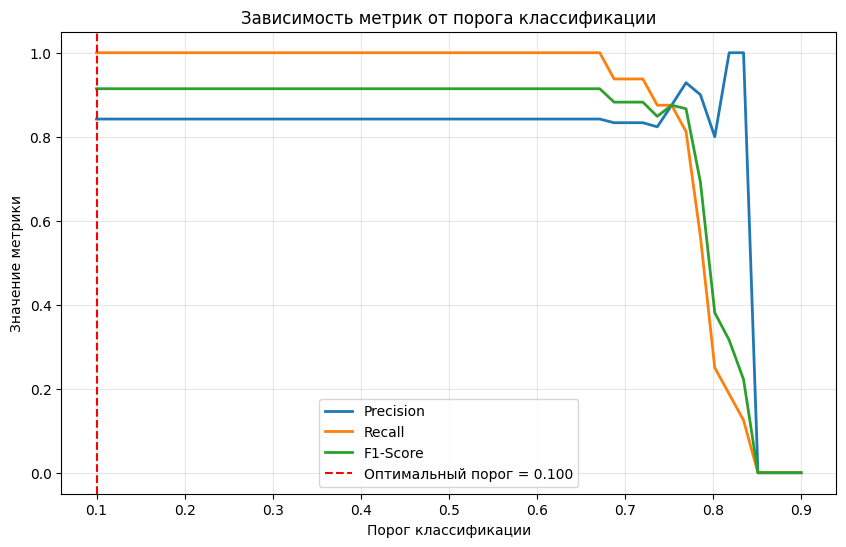

In [5]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, threshold=0.5):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.threshold = threshold
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iterations):
            z = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(z)
            
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        
        return self
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        proba_class_1 = self._sigmoid(z)
        proba = np.zeros((len(X), 2))
        proba[:, 0] = 1 - proba_class_1
        proba[:, 1] = proba_class_1
        return proba
    
    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

def calculate_precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def calculate_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def calculate_f1(y_true, y_pred):
    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

lr_model = LogisticRegression(learning_rate=0.1, n_iterations=1000)
lr_model.fit(X_train, y_train)

thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

proba_val = lr_model.predict_proba(X_val)[:, 1]

for threshold in thresholds:
    y_pred = (proba_val >= threshold).astype(int)
    precisions.append(calculate_precision(y_val, y_pred))
    recalls.append(calculate_recall(y_val, y_pred))
    f1_scores.append(calculate_f1(y_val, y_pred))

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
lr_model.threshold = best_threshold

print(f"Оптимальный порог: {best_threshold:.3f}, F1 на валидации: {f1_scores[best_threshold_idx]:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Оптимальный порог = {best_threshold:.3f}')
plt.xlabel('Порог классификации')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от порога классификации')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Оценка качества

Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:
* accuracy
* precision
* recall
* roc-auc
* постройте матрицу ошибок
  
---

Оцениваем качество всех моделей на тестовой выборке по метрикам accuracy, precision, recall, ROC-AUC и строим матрицы ошибок.

### Матрица ошибок


|   |  0 |  1 | 
|---|----|----|
| 0 | TN | FP |
| 1 | FN | TP |

- TN (True Negative)  - правильно предсказали 0
- TP (True Positive)  - правильно предсказали 1  
- FP (False Positive) - ошибочно предсказали 1 (ошибка I рода)
- FN (False Negative) - ошибочно предсказали 0 (ошибка II рода)

### Accuracy

```
Accuracy = (TP + TN) / (TP + TN + FP + FN)
```

Доля правильных ответов. 

При несбалансированных классах может вводить в заблуждение. 95% писем - не спам. Модель всегда говорит "не спам" -> Accuracy = 95%

### Precision (Точность среди положительных)

```
Precision = TP / (TP + FP)
```

Из всех, кого назвали классом 1, какая доля действительно класс 1. Важна, когда цена ложного срабатывания высока.

### Recall (Полнота)

```
Recall = TP / (TP + FN)
```

Из всех объектов класса 1, какую долю мы нашли. Важна, когда цена пропуска высока.

### ROC-AUC

ROC-кривая показывает соотношение TPR (True Positive Rate) и FPR (False Positive Rate) при разных порогах.

```
TPR = TP / (TP + FN) = Recall
FPR = FP / (FP + TN)
```

AUC (Area Under Curve) - площадь под ROC-кривой:
- AUC = 0.5: модель не лучше случайного угадывания
- AUC = 1.0: идеальная модель
- AUC > 0.7: считается приемлемым

AUC: Вероятность того, что модель даст случайному положительному примеру больший score, чем случайному отрицательному.

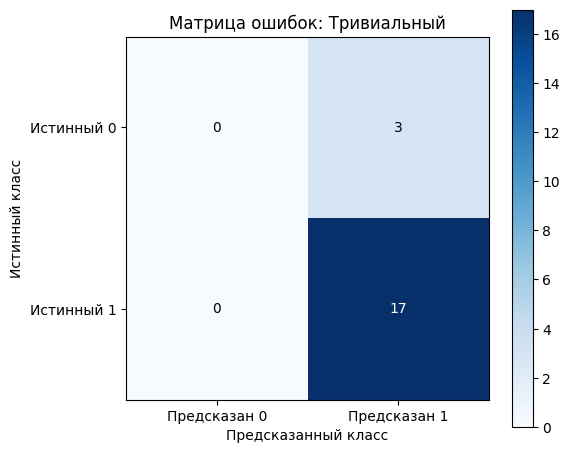

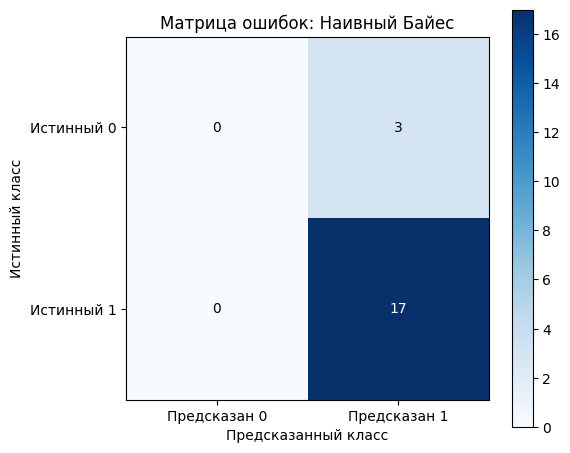

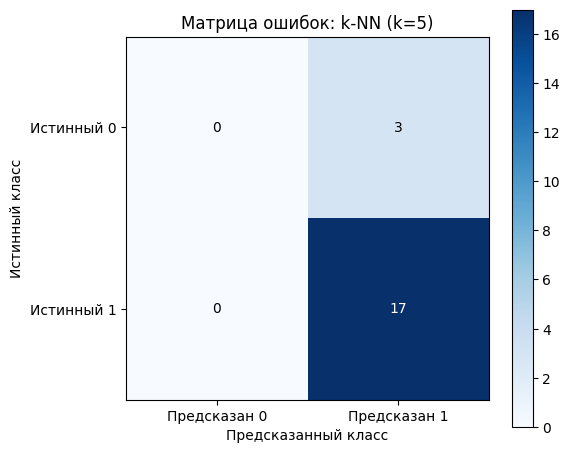

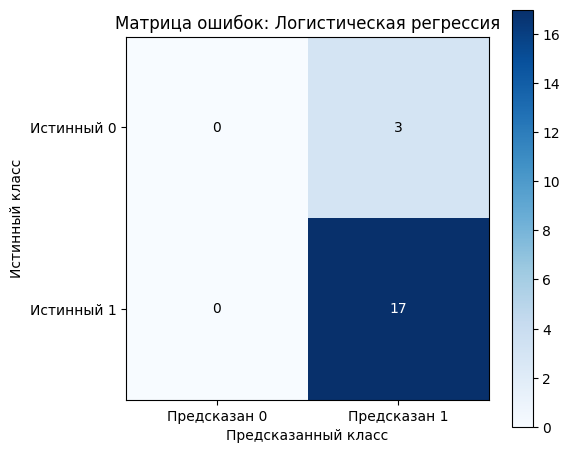

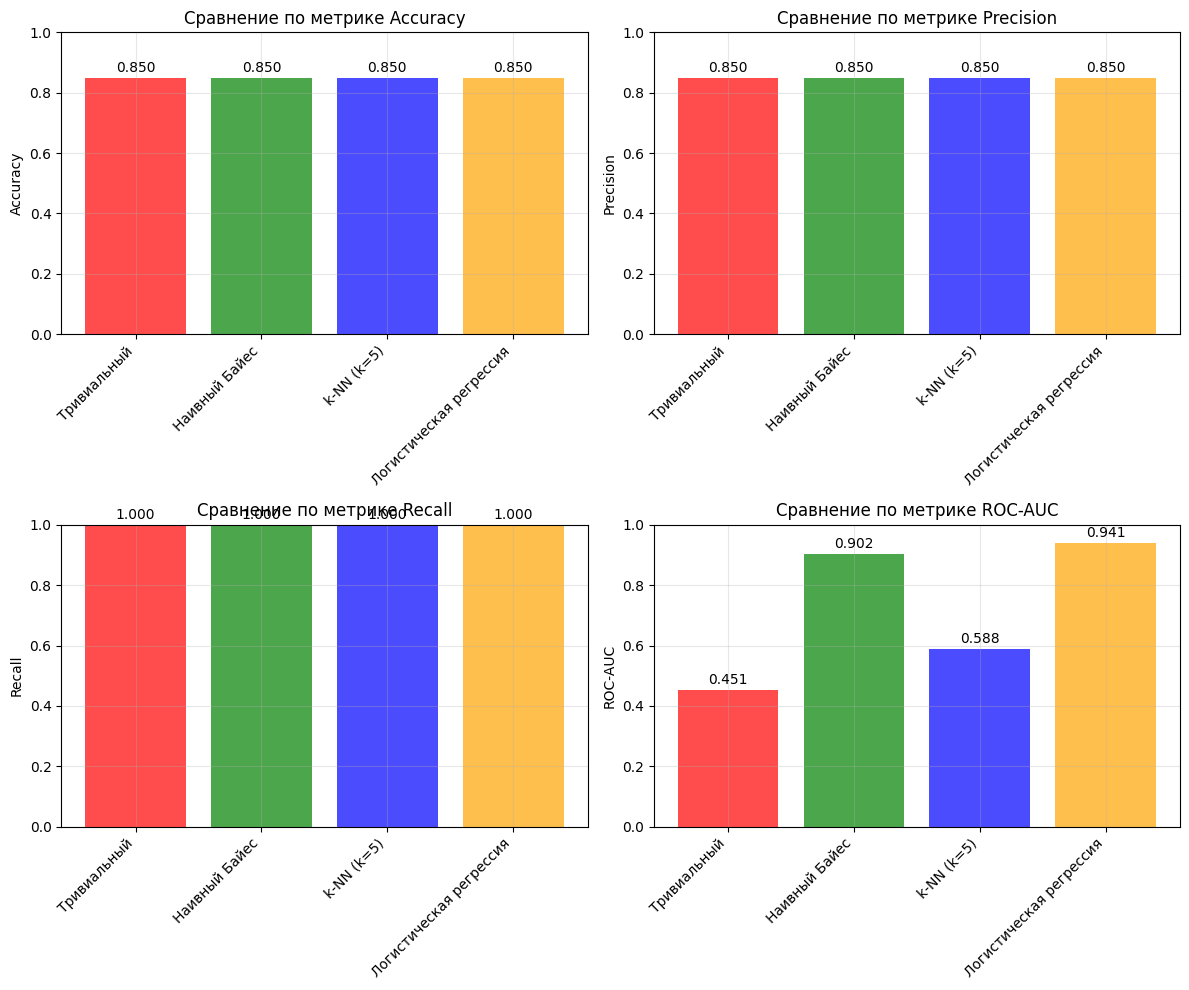

In [6]:
def calculate_roc_auc(y_true, y_proba):
    sorted_idx = np.argsort(y_proba)[::-1]
    y_true_sorted = y_true[sorted_idx]
    
    n_pos = np.sum(y_true == 1)
    n_neg = np.sum(y_true == 0)
    
    tpr = []
    fpr = []
    
    for i in range(len(y_true) + 1):
        tp = np.sum(y_true_sorted[:i] == 1)
        fp = np.sum(y_true_sorted[:i] == 0)
        
        tpr.append(tp / n_pos if n_pos > 0 else 0)
        fpr.append(fp / n_neg if n_neg > 0 else 0)
    
    auc = 0
    for i in range(1, len(tpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    
    return auc

def confusion_matrix(y_true, y_pred):
    matrix = np.zeros((2, 2), dtype=int)
    for true, pred in zip(y_true, y_pred):
        matrix[true, pred] += 1
    return matrix

def plot_confusion_matrix(matrix, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(2),
           yticks=np.arange(2),
           xticklabels=['Предсказан 0', 'Предсказан 1'],
           yticklabels=['Истинный 0', 'Истинный 1'],
           title=title,
           ylabel='Истинный класс',
           xlabel='Предсказанный класс')
    
    # Добавляем значения в ячейки
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, matrix[i, j],
                          ha="center", va="center", color="white" if matrix[i, j] > matrix.max()/2 else "black")
    
    plt.tight_layout()
    return fig

models = {
    'Тривиальный': trivial_model,
    'Наивный Байес': nb_model,
    f'k-NN (k={best_k})': knn_model,
    'Логистическая регрессия': lr_model
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = calculate_accuracy(y_test, y_pred)
    precision = calculate_precision(y_test, y_pred)
    recall = calculate_recall(y_test, y_pred)
    roc_auc = calculate_roc_auc(y_test, y_proba)
    
    results.append({
        'Модель': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc
    })
    
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, f'Матрица ошибок: {name}')
    plt.show()

results_df = pd.DataFrame(results)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']

for ax, metric in zip(axes.flat, metrics):
    values = results_df[metric].values
    models_names = results_df['Модель'].values
    colors = ['red', 'green', 'blue', 'orange']
    
    bars = ax.bar(range(len(models_names)), values, color=colors, alpha=0.7)
    ax.set_xticks(range(len(models_names)))
    ax.set_xticklabels(models_names, rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'Сравнение по метрике {metric}')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()